# Examine Results

In [13]:
from convnwb.io import get_files, load_json, load_jsons_to_df

from spiketools.plts.data import plot_hist, plot_bar
from spiketools.plts.utils import make_axes
from spiketools.plts.annotate import _add_hlines

In [14]:
import seaborn as sns
sns.set_context('talk')

## Settings

In [15]:
# Set which experiment version to run
experiment = 'THF'

In [16]:
# Set the folder to load results from
data_path = '../results/units/' + experiment

In [17]:
# Get the list of files
res_files = get_files(data_path, select='json')

In [18]:
# Check the number of available files
n_files = len(res_files)
n_files

72

## Load Example File

In [19]:
# Load an example file
file = res_files[0]
data = load_json(file, folder=str(data_path))

In [20]:
# Check example file
data

{'session': 'THF_wv001_session_0',
 'uid': 10,
 'wvID': 11,
 'keep': True,
 'cluster': 1571,
 'channel': 'A16',
 'location': 'LAH',
 'n_spikes': 2291,
 'firing_rate': 1838.7560066057742,
 'fr_t_val': -0.335561371762666,
 'fr_p_val': 0.7384783239796033,
 'place_info': 1.6642444829739589,
 'place_p_val': 0.36,
 'place_z_score': 0.5161622973139365,
 'target_info': 3.773372526428895,
 'target_p_val': 0.39,
 'target_z_score': 0.3905937249743087,
 'hd_z_val': 4.319161772293733,
 'hd_p_val': 0.013246385441277002,
 'hd_surr_p': 0.13,
 'hd_surr_z': 1.0980174132116776}

## Collect Results

In [21]:
# Collect all unit results together into a dataframe
all_results = load_jsons_to_df(res_files, folder=data_path)

In [22]:
# Clean up some datatypes - cast integers
set_ints = ['uid', 'wvID', 'keep', 'cluster', 'n_spikes']
all_results[set_ints] = all_results[set_ints].astype('int')

In [23]:
# Check the columns
all_results.columns

Index(['session', 'uid', 'wvID', 'keep', 'cluster', 'channel', 'location',
       'n_spikes', 'firing_rate', 'fr_t_val', 'fr_p_val', 'place_info',
       'place_p_val', 'place_z_score', 'target_info', 'target_p_val',
       'target_z_score', 'hd_z_val', 'hd_p_val', 'hd_surr_p', 'hd_surr_z',
       'fr_t_val_all', 'fr_p_val_all', 'fr_t_val_empt', 'fr_p_val_empt',
       'fr_t_val_full', 'fr_p_val_full', 'sp_p_val_0', 'sp_p_val_1',
       'sp_p_val_2', 'sp_p_val_3', 'sp_z_score_0', 'sp_z_score_1',
       'sp_z_score_2', 'sp_z_score_3'],
      dtype='object')

In [24]:
# Check the head of the results
all_results.head()

,session,uid,wvID,keep,cluster,channel,location,n_spikes,firing_rate,fr_t_val,...,fr_t_val_full,fr_p_val_full,sp_p_val_0,sp_p_val_1,sp_p_val_2,sp_p_val_3,sp_z_score_0,sp_z_score_1,sp_z_score_2,sp_z_score_3
0,THF_wv001_session_0,10,11,1,1571,A16,LAH,2291,1838.756007,-0.335561,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,THF_wv001_session_0,11,12,1,2044,A17,LPH,1400,1110.418593,-0.204255,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,THF_wv001_session_0,12,13,1,2130,A17,LPH,702,555.959172,-0.448272,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,THF_wv001_session_0,13,14,1,2195,A17,LPH,635,502.897181,0.360277,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,THF_wv001_session_0,14,15,1,2207,A17,LPH,1135,898.879457,-3.039444,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Location Checks

In [25]:
# Check the set of sampled locations
locations = set(all_results['location'])
locations

{'LA', 'LAH', 'LPH', 'RA', 'RAH'}

In [26]:
# Check location counts
all_results['location'].value_counts()

LPH    27
LAH    19
RA      9
RAH     9
LA      8
Name: location, dtype: int64

<AxesSubplot:>

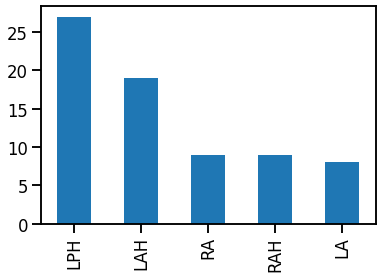

In [27]:
# Plot the counts per location
all_results['location'].value_counts().plot(kind='bar')

In [28]:
# Define location map
locmap = {'LA' : 'amygdala',
          'RA' : 'amygdala',
          'LAH' : 'ant hipp',
          'RAH' : 'ant hipp',
          'LPH' : 'post hipp',
          'RPH' : 'post hipp'}

In [29]:
# Set and collect which area each unit it is
all_results['area'] = all_results['location'].map(locmap)

In [30]:
# Check area counts
all_results['area'].value_counts()

ant hipp     28
post hipp    27
amygdala     17
Name: area, dtype: int64

<AxesSubplot:>

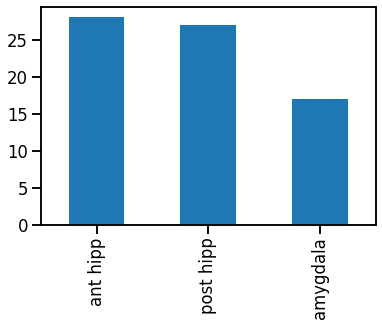

In [31]:
# Plot the counts per area
all_results['area'].value_counts().plot(kind='bar')

In [32]:
# Check the set of sampled areas
areas = set(all_results['area'])
areas

{'amygdala', 'ant hipp', 'post hipp'}

### Firing Rate Checks

In [33]:
# Note: is an inf value for firing rate...

In [34]:
# Plot the distribution of firing rates
#plot_hist(all_results['firing_rate'].values)

In [35]:
# Add a marker for firing rate threshold in the TH experiment
all_results['fr_keep_th'] = (all_results['firing_rate'] < 0.5).values

### Binary labels

In [ ]:
# Set significance level
ALPHA_LEVEL = 0.05

In [ ]:
# Add binary labels for statistical tests
all_results['is_chest_cell'] = all_results['fr_p_val_all'] < ALPHA_LEVEL
all_results['is_full_cell'] = all_results['fr_p_val_full'] < ALPHA_LEVEL
all_results['is_empty_cell'] = all_results['fr_p_val_empt'] < ALPHA_LEVEL
all_results['is_place_cell'] = all_results['place_p_val'] < ALPHA_LEVEL
all_results['is_target_cell'] = all_results['target_p_val'] < ALPHA_LEVEL
all_results['is_sp_cell'] = all_results['sp_p_val'] < ALPHA_LEVEL
#all_results['is_head_direction_cell'] = all_results['hd_p_val'] < ALPHA_LEVEL

### Check numbers

In [ ]:
# Check the total number of cells
print('Total number of cells: {}'.format(n_files))

## Check Results

In [ ]:
# Define list of analyses
analyses = ['chest', 'full', 'empty', 'place', 'target', 'sp']

In [ ]:
# Get total number of units
n_units = len(all_results)

In [ ]:
# Collect numbers of significant cells
results = {}
for analysis in analyses:
    results[analysis] = sum(all_results['is_' + analysis + '_cell'])

In [ ]:
# Check the number & percent of significant cells per analysis
print('{} - total cells: {}\n'.format(experiment, n_units))
for analysis in analyses:
    print('# {} cells:     \t\t{:3d}  ({:5.2f}%)'.format(\
        analysis, results[analysis], results[analysis] / n_units * 100))

### Results by Area

In [ ]:
#location

In [ ]:
places = {'area' : areas, 'location' : locations}
place = 'area'

In [ ]:
axes = make_axes(len(analyses), 3, hspace=0.35, figsize=(18, 10))
for analysis, ax in zip(analyses, axes):

    out = {}
    out['all'] = results[analysis] / n_units

    for value in places[place]:
        temp = all_results[all_results[place] == value]
        out[value] = sum(temp['is_' + analysis + '_cell']) / len(temp)

    plot_bar(out.values(), out.keys(), title=analysis, ylim=[0, 0.30], ax=ax)
    _add_hlines(0.05, linestyle='--', color='black', ax=ax)

## Distributions

In [ ]:
# Plot settings
bins = 25

### Chest Measures

In [ ]:
# Plot t-values of the chest measures
axes = make_axes(3, 3, figsize=(15, 4))
plot_hist(all_results.fr_t_val_all.values, title='Chests (all) - t values', bins=bins, ax=axes[0])
plot_hist(all_results.fr_t_val_full.values, title='Chests (full) - t values', bins=bins, ax=axes[1])
plot_hist(all_results.fr_t_val_empt.values, title='Chests (empty) - t values', bins=bins, ax=axes[2])

In [ ]:
# Plot p-values of the chest measures
axes = make_axes(3, 3, figsize=(15, 4))
plot_hist(all_results.fr_p_val_all.values, title='Chests (all) - p values', bins=bins, ax=axes[0])
plot_hist(all_results.fr_p_val_full.values, title='Chests (full) - p values', bins=bins, ax=axes[1])
plot_hist(all_results.fr_p_val_empt.values, title='Chests (empty) - p values', bins=bins, ax=axes[2])

### Position & Sequence Measures

In [ ]:
# Plot measure values of the position & sequence measures
axes = make_axes(3, 3, figsize=(15, 4))
plot_hist(all_results.place_value.values, title='Place - measures', bins=bins, ax=axes[0])
plot_hist(all_results.target_value.values, title='Target - measures', bins=bins, ax=axes[1])
plot_hist(all_results.sp_value.values, title='Serial Position - measures', bins=bins, ax=axes[2])

In [ ]:
# Plot surrogate z-scores of the position & sequence measures
axes = make_axes(3, 3, figsize=(15, 4))
plot_hist(all_results.place_z_score.values, title='Place - z score', ax=axes[0])
plot_hist(all_results.target_z_score.values, title='Target - z score', ax=axes[1])
plot_hist(all_results.sp_z_score.values, title='Serial Position - z score', ax=axes[2])

In [ ]:
# Plot p values of the position & sequence measures
axes = make_axes(3, 3, figsize=(15, 4))
plot_hist(all_results.place_p_val.values, title='Place - p values', bins=bins, ax=axes[0])
plot_hist(all_results.target_p_val.values, title='Target - p values', bins=bins, ax=axes[1])
plot_hist(all_results.sp_p_val.values, title='Serial Position - p values', bins=bins, ax=axes[2])

## Save out results

In [ ]:
# Save out of CSV
#all_results.to_csv(experiment + '_all_results.csv')